In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### The purpose of this notebook is to explore using dgl libaray for GAT implementation

In [2]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import numpy as np
from tqdm import tqdm

pd.set_option('display.max_rows', 100)

#### Get all the relevant graphs

In [3]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
processed_data_path = here() / "data/ghesquire_2011/processed_data.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

# the cleaned data has everything processed and ready to be used for deep learning
with open(processed_data_path, "rb") as f:
    processed_data = pkl.load(f)
    

# select the graphs that only exist in fitered dataset
# one cannot directly loop through the dict keys, and delete certain ones b/c it is changing 
graphs_to_remove = []
for graph_key in graphs.keys():
    if graph_key not in processed_data["accession-sequence"].tolist():
        print(graph_key)
        graphs_to_remove.append(graph_key)
for graph_key in graphs_to_remove:
    graphs.pop(graph_key)
print(f"the filtered graphs has {len(list(graphs.values()))} graphs")

Q8IXH7-MFTSMDPPPVELIR
P00492-VFIPHGLIMDR
O75874-LIDDMVAQAMK
P67936-MEIQEMQLK
the filtered graphs has 359 graphs


##### Convert networkx graphs to dgl graph objects, then put it into a dataset

In [4]:
from patch_gnn.dgl_dataset import get_graph_and_feat_df,convert_networkx_to_dgl,PatchGNNDataset

Using backend: pytorch


In [5]:
all_networkx_graphs, all_graph_features, accession_num = get_graph_and_feat_df(graphs, processed_data)
all_networkx_graphs = [graph.to_directed() for graph in all_networkx_graphs]
targets = processed_data['ox_fwd_logit'].values
train_dataset = PatchGNNDataset(
                 networkx_graphs= all_networkx_graphs[:251],
                 labels = targets[:251],
                 features= all_graph_features[:251])
test_dataset = PatchGNNDataset(
                 networkx_graphs= all_networkx_graphs[251:],
                 labels = targets[251:],
                 features= all_graph_features[251:])


100%|██████████| 108/108 [00:00<00:00, 3009.63it/s]


In [6]:
# indexing datasets returns dgl_graph, target value and node names
idx = 4
one_dgl_graph, one_graph_node, one_graph_label = train_dataset[idx]

print(f"sample {idx} nodes is {one_graph_node}, target is {one_graph_label}")
one_dgl_nodes = list(one_graph_node.values())

sample 4 nodes is {0: '402CYS', 1: '405ILE', 2: '409LEU', 3: '437ASP', 4: '438MET', 5: '439ILE', 6: '442TRP', 7: '573LEU', 8: '576ILE'}, target is -3.8092901706695557


#### Construct a GATN model
Import relevant modules

In [7]:
from patch_gnn.dgl_layer import GATN
from patch_gnn.dgl_dataset import collate_fn
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from dgl.dataloading import GraphDataLoader
import dgl
from patch_gnn.dgl_cv_split import k_fold_split

##### Add cross validation split

In [8]:
all_folds = k_fold_split(train_dataset, k=3)
for train_fold, val_fold in all_folds:
    print(len(train_fold), len(val_fold))
len(all_folds[0][0]), len(all_folds[0][1]), all_folds[0][0][0]

168 83
167 84
167 84


(168,
 83,
 (Graph(num_nodes=7, num_edges=20,
        ndata_schemes={'feat': Scheme(shape=(67,), dtype=torch.float32)}
        edata_schemes={}),
  {0: '252TRP',
   1: '281PHE',
   2: '283PRO',
   3: '285GLU',
   4: '286MET',
   5: '287LYS',
   6: '289LEU'},
  tensor(-3.4095)))

#### Get cross validation performance

In [9]:
from patch_gnn.dgl_train_gatn import reset_weights, cv_on_train_with_gatn

Here it will be nice to evaluate the cv performance with different **learning rate**, and different number of **heads**

100%|██████████| 7000/7000 [01:28<00:00, 79.38it/s]


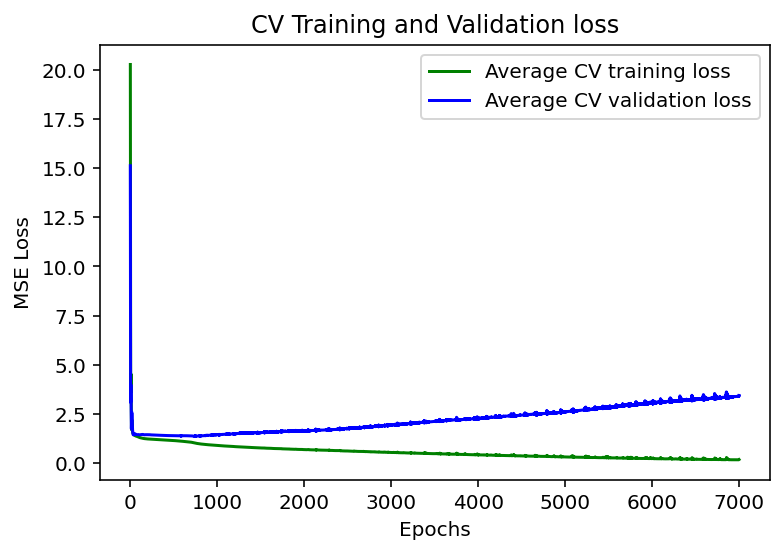

In [10]:
lr = 1e-4
avg_loss_per_epoch_train, avg_loss_per_epoch_val = cv_on_train_with_gatn(
    train_dataset,
    lr = lr,
    n_epochs = 7000,
    gat_n_heads = 1,
)

##### Based on the cross validation performance from the above, select appropriate number of epochs for training, then save the trained model to file. 
Here no cross validation will be used because we want to use more training data (instead of splitting training into training and validation set)

In [13]:
from patch_gnn.dgl_train_gatn import train_val_with_gatn_no_cv
train_loader = GraphDataLoader(train_dataset, batch_size = len(train_dataset), collate_fn =collate_fn)
test_loader = GraphDataLoader(test_dataset, batch_size = len(test_dataset), collate_fn =collate_fn)

In [14]:
n_epochs = 1000
train_val_with_gatn_no_cv(
    lr_lst = [lr],
    train_loader = train_loader,
    test_loader =  test_loader,
    save_checkpoint = True,
    n_epochs = n_epochs
)

100%|██████████| 1000/1000 [00:16<00:00, 61.05it/s]

epoch 999, learning rate 0.0001, training             mseloss 0.8102381825447083,             test mseloss 3.4195923805236816


#### load saved model and re-evaluate on test set
below code block can be optimized

In [15]:
net = torch.load(f"best_gatn_{lr}.pkl")
net.eval()
mse_loss = nn.MSELoss()
train_loader = GraphDataLoader(train_dataset, batch_size = len(train_dataset), collate_fn =collate_fn)
for train_graphs, train_targets in train_loader:
    pred_train_target, _ = net(train_graphs, 
                 train_graphs.ndata["feat"]) 
    # both pred and train labels are tensor.size([1])
    train_actual_loss = mse_loss(pred_train_target.float(), train_targets.float().unsqueeze(1))

test_loader = GraphDataLoader(test_dataset, batch_size = len(test_dataset), collate_fn =collate_fn)
for test_graphs, test_targets in test_loader:
    pred_test_target, _ = net(test_graphs, 
                 test_graphs.ndata["feat"]) 
    # both pred and train labels are tensor.size([1])
    test_actual_loss = mse_loss(pred_test_target.float(), test_targets.float().unsqueeze(1))

# get attention
# use batch_size =1, get list and append attention to the list
attention_list = list()
test_loss_list = list()

for test_idx in range(len(test_dataset)):
    one_graph, one_graph_nodes, one_graph_target = test_dataset[test_idx]
    pred_one_target, attention = net(one_graph, one_graph.ndata["feat"]) 
    attention_list.append(attention)
    test_one_loss = mse_loss(pred_one_target.float()[0][0], 
                             one_graph_target.float())
    test_loss_list.append(test_one_loss)

##### get performance metric

In [16]:
from scipy.stats import pearsonr
train_pearsonr, train_pearsonr_p = pearsonr(pred_train_target.detach().numpy().squeeze(), train_targets.squeeze())
test_pearsonr, test_pearsonr_p = pearsonr(pred_test_target.detach().numpy().squeeze(), test_targets.squeeze())
print(f"the pearson correlation on train set is {train_pearsonr}, p value is {train_pearsonr_p}")
print(f"the pearson correlation on test set is {test_pearsonr}, p value is {test_pearsonr_p}")

the pearson correlation on train set is 0.6825236798903986, p value is 9.173892947004842e-36
the pearson correlation on test set is -0.055281280169255195, p value is 0.5698653984416232


Text(0.5, 1.0, 'GATN, Test Perf: -0.805')

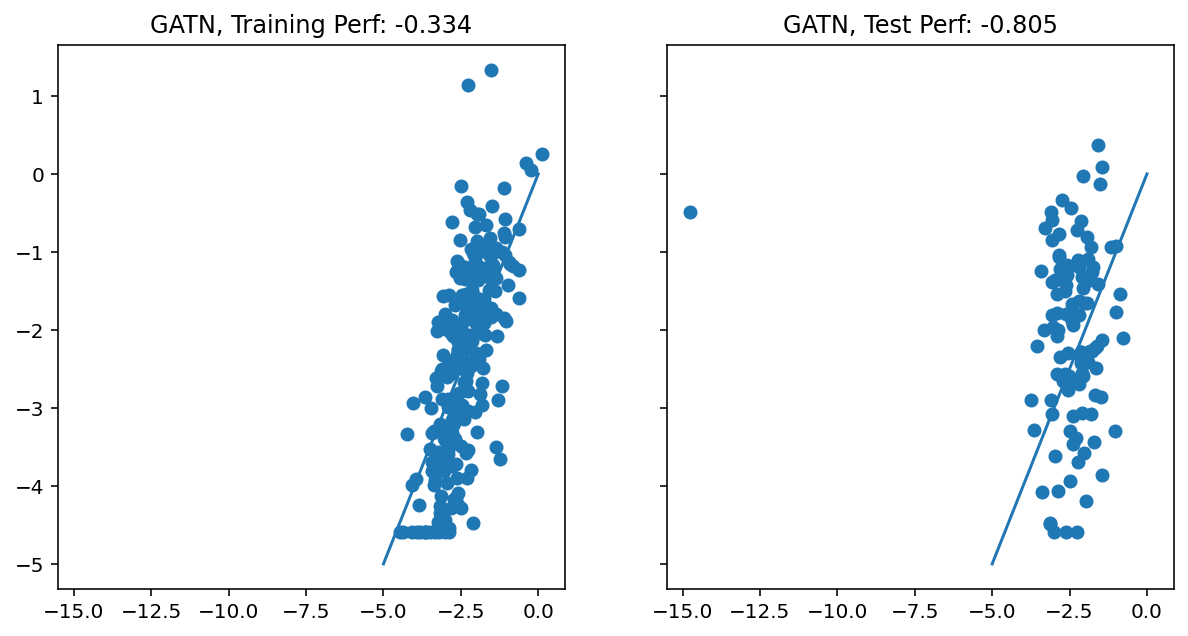

In [17]:
fig, ax = plt.subplots(
        figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True,
    )
ax[0].scatter(pred_train_target.detach().numpy().squeeze(), train_targets.squeeze())
ax[0].plot([-5, 0], [-5, 0])
ax[0].set_title(f"GATN, Training Perf: {evs(pred_train_target.detach().numpy().squeeze(), train_targets.squeeze()):.3f}")

ax[1].scatter(pred_test_target.detach().numpy().squeeze(), test_targets.squeeze())
ax[1].plot([-5, 0], [-5, 0])
ax[1].set_title(f"GATN, Test Perf: {evs(pred_test_target.detach().numpy().squeeze(), test_targets.squeeze()):.3f}")

##### draw attention derived from the model on selected graphs

In [18]:
from patch_gnn.dgl_train_gatn import get_attention_plot

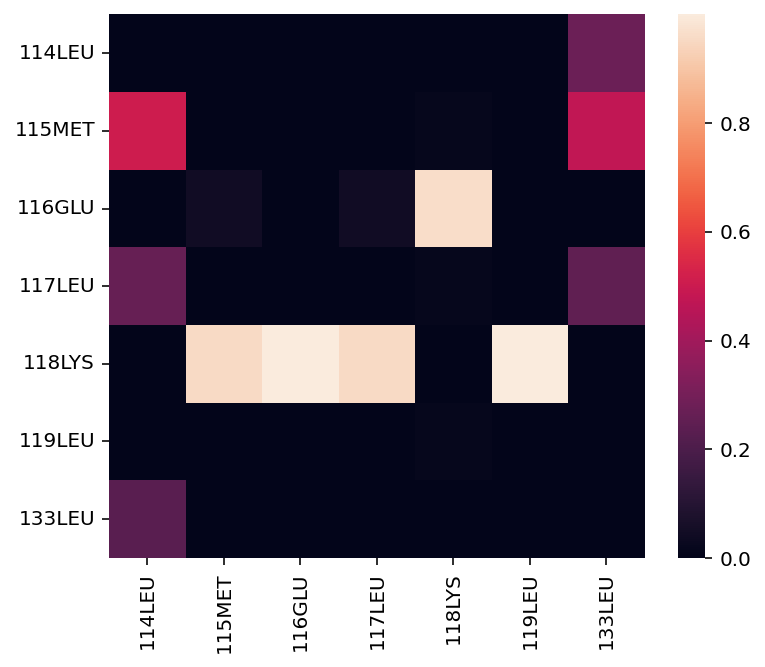

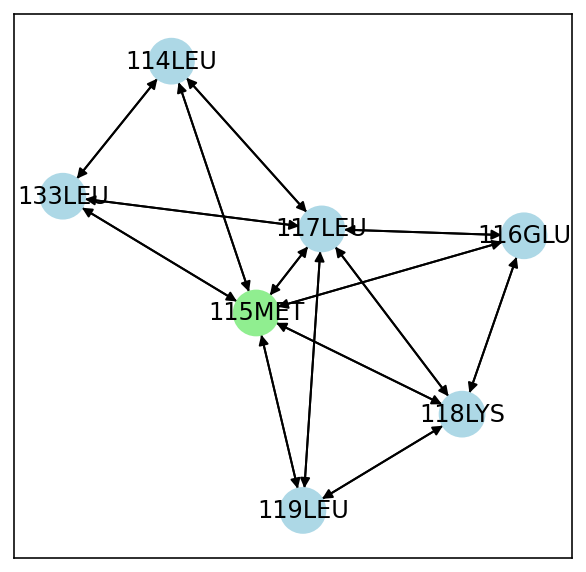

In [19]:
a3 =get_attention_plot(test_dataset =test_dataset, idx = 3, attention_list =attention_list )

In [20]:
#visualize attention matrix
pd.DataFrame(a3)

,0,1,2,3,4,5,6
0,0.000000,0.000010,0.000000,0.000010,0.000000,0.000000,0.276685
1,0.504456,0.000000,0.000019,0.000018,0.013589,0.000019,0.474277
2,0.000000,0.045169,0.000000,0.045168,0.962140,0.000000,0.000000
3,0.264886,0.000009,0.000010,0.000000,0.011946,0.000010,0.249038
4,0.000000,0.954792,0.999972,0.954784,0.000000,0.999972,0.000000
5,0.000000,0.000011,0.000000,0.000011,0.012325,0.000000,0.000000
6,0.230658,0.000008,0.000000,0.000008,0.000000,0.000000,0.000000


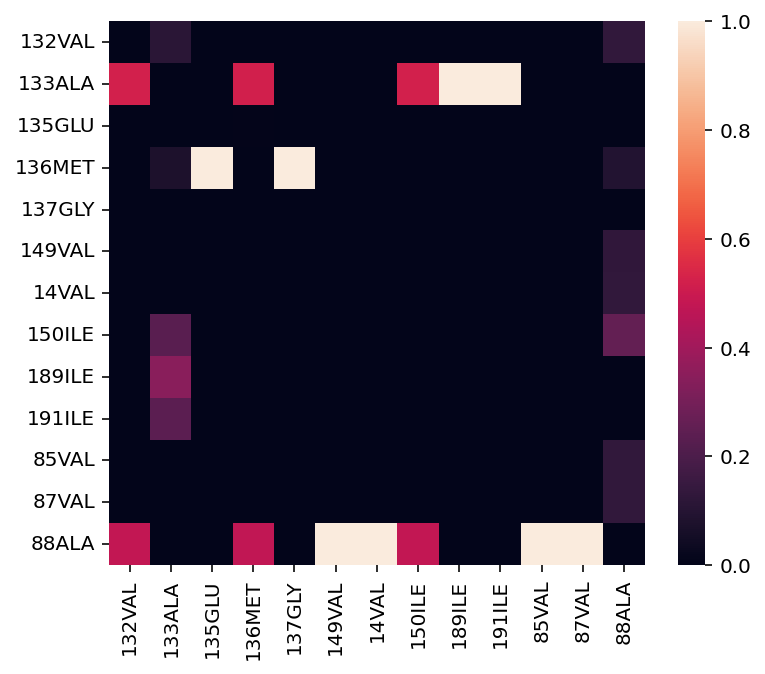

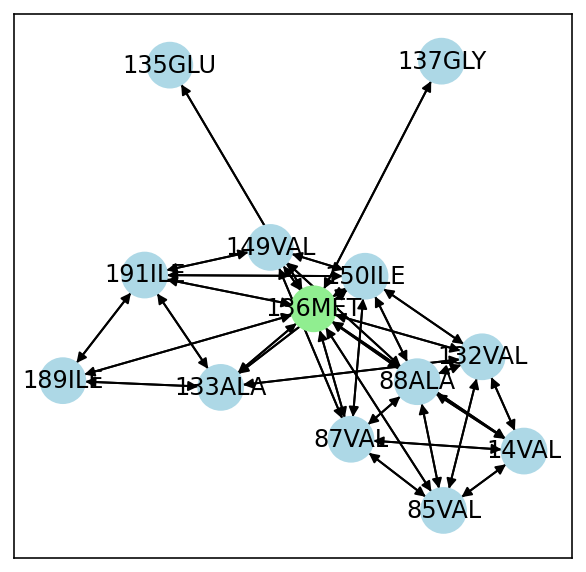

In [21]:
a20 = get_attention_plot(test_dataset =test_dataset, idx = 20, attention_list =attention_list )

In [22]:
#visualize attention matrix
pd.DataFrame(a20)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000000,0.109997,0.0,0.000006,0.0,0.000000,0.000013,0.000070,0.000000,0.000000,0.000013,0.000000,0.129242
1,0.522600,0.000000,0.0,0.519062,0.0,0.000000,0.000000,0.522472,0.999699,0.999107,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.005762,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000003,0.076795,1.0,0.000000,1.0,0.000008,0.000006,0.000049,0.000060,0.000108,0.000007,0.000007,0.090231
4,0.000000,0.000000,0.0,0.000686,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.0,0.000006,0.0,0.000000,0.000000,0.000070,0.000000,0.000154,0.000000,0.000013,0.128395
6,0.000007,0.000000,0.0,0.000007,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015,0.000015,0.132807
7,0.000123,0.231783,0.0,0.000122,0.0,0.000258,0.000000,0.000000,0.000000,0.000281,0.000000,0.000258,0.256545
8,0.000000,0.344453,0.0,0.000182,0.0,0.000000,0.000000,0.000000,0.000000,0.000350,0.000000,0.000000,0.000000
9,0.000000,0.236971,0.0,0.000125,0.0,0.000263,0.000000,0.000127,0.000241,0.000000,0.000000,0.000000,0.000000


In [ ]:
2**13